# DeBERTa V2 Model Evaluation

**Purpose**: Evaluate a pre-trained DeBERTa V2 XLarge model for fallacy detection

**Features**:
- Load saved model
- Generate predictions on test set
- Classification report with per-class metrics
- Normalized confusion matrix visualization

---

## Step 1: Import Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from tqdm import tqdm

# HuggingFace
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DebertaV2Tokenizer

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)

import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

All libraries imported successfully!
PyTorch version: 2.9.1


## Step 2: Configuration

In [2]:
@dataclass
class EvalConfig:
    """
    Configuration for model evaluation.
    """
    
    # Model path (update this to your saved model location)
    model_path: str = "./best_model"
    
    # Data paths
    test_data_path: str = "Data/fallacy_test.csv"
    val_data_path: str = "Data/fallacy_val.csv"
    
    # Output
    output_dir: str = "./output/evaluation"
    
    # Model settings
    max_seq_length: int = 512


config = EvalConfig()

# Create output directory
Path(config.output_dir).mkdir(parents=True, exist_ok=True)

print("="*70)
print("EVALUATION CONFIGURATION")
print("="*70)
print(f"\nModel Path: {config.model_path}")
print(f"Test Data: {config.test_data_path}")
print(f"Validation Data: {config.val_data_path}")
print(f"Output Directory: {config.output_dir}")
print("="*70)

EVALUATION CONFIGURATION

Model Path: ./best_model
Test Data: Data/fallacy_test.csv
Validation Data: Data/fallacy_val.csv
Output Directory: ./output/evaluation


## Step 3: Setup Device

In [3]:
print("="*70)
print("DEVICE CONFIGURATION")
print("="*70)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = f"CUDA GPU: {torch.cuda.get_device_name(0)}"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"\nUsing: {device_name}")
print(f"Device: {device}")
print("="*70)

DEVICE CONFIGURATION

Using: Apple Silicon GPU (MPS)
Device: mps


## Step 4: Load Model

In [4]:
print("="*70)
print("LOADING MODEL")
print("="*70)

print(f"\nLoading model from: {config.model_path}")
print("This may take a moment...\n")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(config.model_path)
model.to(device)
model.eval()

# Load tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained(config.model_path)

# Get label mappings
id2label = model.config.id2label
label2id = model.config.label2id
num_labels = len(id2label)
label_names = [id2label[i] for i in range(num_labels)]

print("Model loaded successfully!")
print(f"\nModel Parameters: {model.num_parameters():,}")
print(f"Number of Labels: {num_labels}")
print(f"\nFallacy Classes:")
for idx, label in id2label.items():
    print(f"  {idx}: {label}")
print("="*70)

LOADING MODEL

Loading model from: ./best_model
This may take a moment...

Model loaded successfully!

Model Parameters: 886,972,428
Number of Labels: 12

Fallacy Classes:
  0: ad hominem
  1: anecdote
  2: cherry picking
  3: conspiracy theory
  4: fake experts
  5: false choice
  6: false equivalence
  7: impossible expectations
  8: misrepresentation
  9: oversimplification
  10: single cause
  11: slothful induction


## Step 5: Load Test Data

In [5]:
print("="*70)
print("LOADING DATA")
print("="*70)

# Load test dataset
test_dataset = load_dataset("csv", data_files=config.test_data_path, split="train")
print(f"\nTest samples: {len(test_dataset)}")

# Load validation dataset
val_dataset = load_dataset("csv", data_files=config.val_data_path, split="train")
print(f"Validation samples: {len(val_dataset)}")

print("="*70)

LOADING DATA


Generating train split: 0 examples [00:00, ? examples/s]


Test samples: 256


Generating train split: 0 examples [00:00, ? examples/s]

Validation samples: 457


## Step 6: Generate Predictions

Run inference on the test set to generate predictions.

In [6]:
def get_predictions(dataset, model, tokenizer, device, label2id):
    """
    Generate predictions for a dataset.
    
    Args:
        dataset: HuggingFace dataset
        model: Trained model
        tokenizer: Tokenizer
        device: torch device
        label2id: Label to ID mapping
        
    Returns:
        Tuple of (true_labels, predictions, probabilities)
    """
    true_labels = []
    predictions = []
    all_probs = []
    
    model.eval()
    
    for example in tqdm(dataset, desc="Generating predictions"):
        # Tokenize
        inputs = tokenizer(
            example["text"],
            return_tensors="pt",
            truncation=True,
            max_length=config.max_seq_length
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
        
        predictions.append(pred)
        true_labels.append(label2id[example["label"]])
        all_probs.append(probs.cpu().numpy()[0])
    
    return np.array(true_labels), np.array(predictions), np.array(all_probs)


print("="*70)
print("GENERATING TEST PREDICTIONS")
print("="*70 + "\n")

test_labels, test_preds, test_probs = get_predictions(
    test_dataset, model, tokenizer, device, label2id
)

print(f"\nPredictions generated for {len(test_preds)} samples")
print("="*70)

GENERATING TEST PREDICTIONS



Generating predictions: 100%|██████████| 256/256 [00:23<00:00, 10.90it/s]


Predictions generated for 256 samples


## Step 7: Classification Report (Test Set)

In [7]:
print("="*70)
print("CLASSIFICATION REPORT (Test Set)")
print("="*70 + "\n")

# Calculate overall metrics
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted', zero_division=0
)

print(f"Overall Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

print("\n" + "-"*70)
print("\nPer-Class Metrics:\n")
print(classification_report(
    test_labels,
    test_preds,
    target_names=label_names,
    zero_division=0
))
print("="*70)

CLASSIFICATION REPORT (Test Set)

Overall Metrics:
  Accuracy:  0.6875
  Precision: 0.7295
  Recall:    0.6875
  F1 Score:  0.6916

----------------------------------------------------------------------

Per-Class Metrics:

                         precision    recall  f1-score   support

             ad hominem       0.85      0.76      0.80        37
               anecdote       0.84      0.88      0.86        24
         cherry picking       0.64      0.68      0.66        31
      conspiracy theory       0.75      0.68      0.71        22
           fake experts       1.00      0.86      0.92         7
           false choice       0.80      0.57      0.67         7
      false equivalence       0.43      0.38      0.40         8
impossible expectations       0.53      0.86      0.65        21
      misrepresentation       0.92      0.55      0.69        22
     oversimplification       0.59      0.80      0.68        20
           single cause       0.89      0.53      0.67      

## Step 8: Confusion Matrix (Test Set)

CONFUSION MATRIX (Test Set)

Saved to: output/evaluation/confusion_matrix_test.png


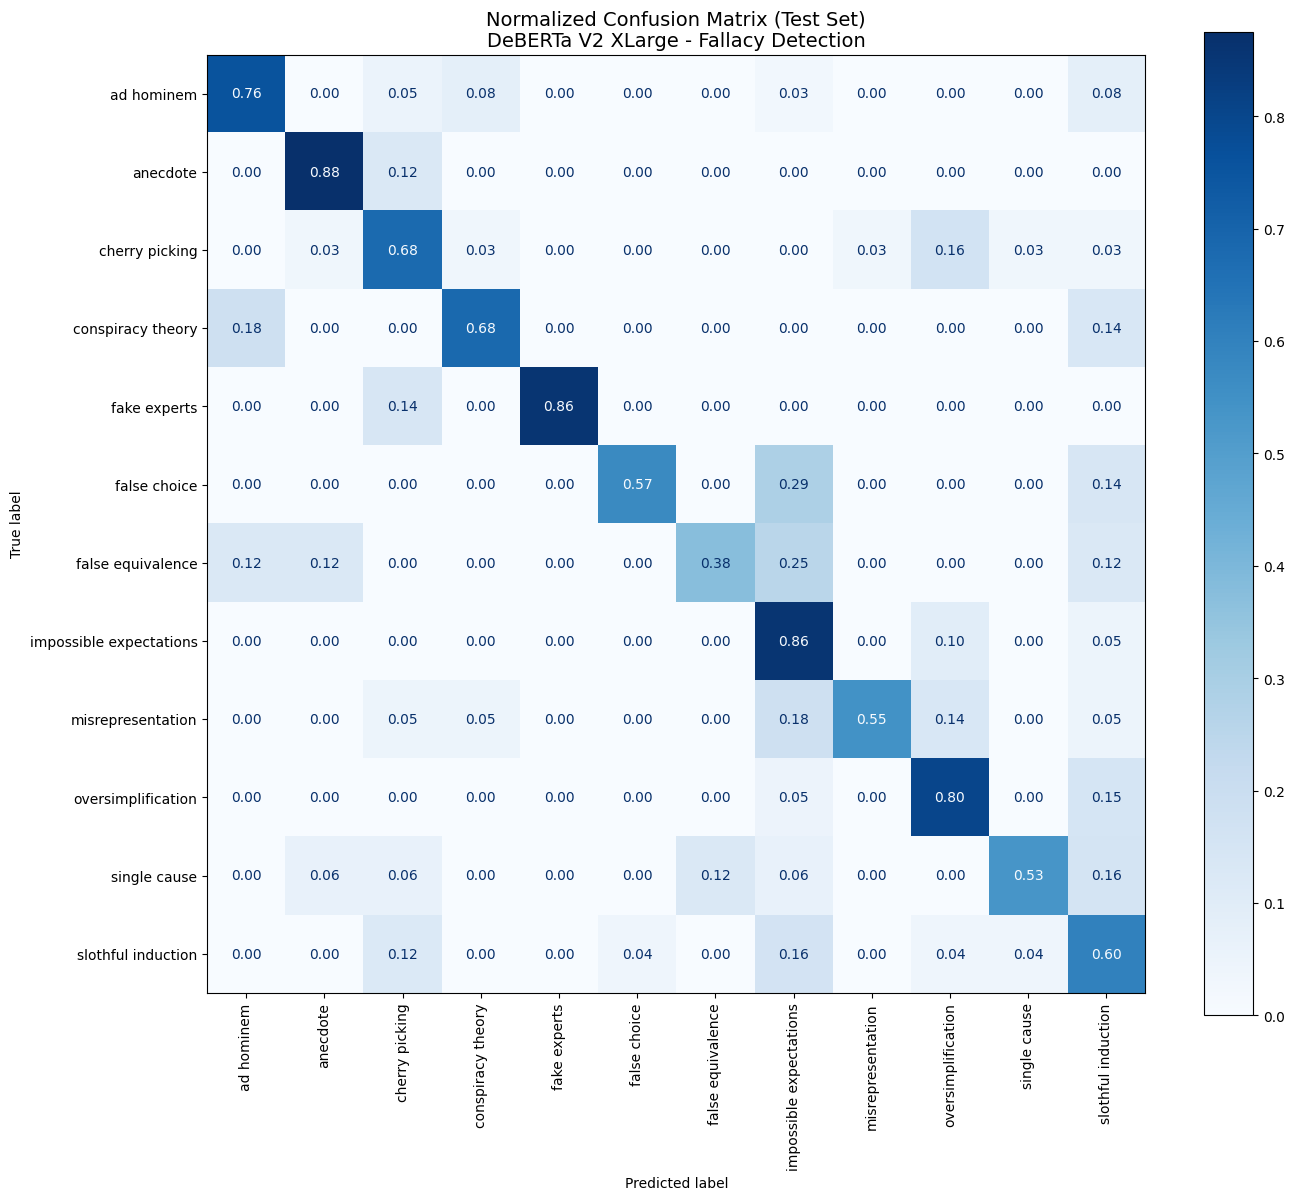

In [8]:
print("="*70)
print("CONFUSION MATRIX (Test Set)")
print("="*70 + "\n")

# Create normalized confusion matrix
cm = confusion_matrix(test_labels, test_preds, normalize='true')

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(
    cmap="Blues",
    values_format=".2f",
    ax=ax,
    colorbar=True,
    xticks_rotation='vertical'
)
plt.title("Normalized Confusion Matrix (Test Set)\nDeBERTa V2 XLarge - Fallacy Detection", fontsize=14)
plt.tight_layout()

# Save
save_path = Path(config.output_dir) / "confusion_matrix_test.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved to: {save_path}")

plt.show()
print("="*70)

## Step 9: Validation Set Evaluation (Optional)

In [9]:
print("="*70)
print("GENERATING VALIDATION PREDICTIONS")
print("="*70 + "\n")

val_labels, val_preds, val_probs = get_predictions(
    val_dataset, model, tokenizer, device, label2id
)

# Calculate metrics
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    val_labels, val_preds, average='weighted', zero_division=0
)

print(f"\nValidation Set Metrics:")
print(f"  Accuracy:  {val_accuracy:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1 Score:  {val_f1:.4f}")
print("="*70)

GENERATING VALIDATION PREDICTIONS



Generating predictions: 100%|██████████| 457/457 [00:31<00:00, 14.38it/s]


Validation Set Metrics:
  Accuracy:  0.7155
  Precision: 0.7599
  Recall:    0.7155
  F1 Score:  0.7202


## Step 10: Save Evaluation Report

In [10]:
import json

# Create evaluation report
evaluation_report = {
    "model_path": config.model_path,
    "test_results": {
        "samples": len(test_labels),
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1)
    },
    "validation_results": {
        "samples": len(val_labels),
        "accuracy": float(val_accuracy),
        "precision": float(val_precision),
        "recall": float(val_recall),
        "f1_score": float(val_f1)
    },
    "label_names": label_names
}

# Save report
report_path = Path(config.output_dir) / "evaluation_report.json"
with open(report_path, "w") as f:
    json.dump(evaluation_report, f, indent=2)

print("="*70)
print("EVALUATION REPORT SAVED")
print("="*70)
print(f"\nReport saved to: {report_path}")
print(f"\nSummary:")
print(json.dumps(evaluation_report, indent=2))
print("="*70)

EVALUATION REPORT SAVED

Report saved to: output/evaluation/evaluation_report.json

Summary:
{
  "model_path": "./best_model",
  "test_results": {
    "samples": 256,
    "accuracy": 0.6875,
    "precision": 0.729484240157131,
    "recall": 0.6875,
    "f1_score": 0.6916056924288945
  },
  "validation_results": {
    "samples": 457,
    "accuracy": 0.7155361050328227,
    "precision": 0.7598699865182037,
    "recall": 0.7155361050328227,
    "f1_score": 0.7202381032353387
  },
  "label_names": [
    "ad hominem",
    "anecdote",
    "cherry picking",
    "conspiracy theory",
    "fake experts",
    "false choice",
    "false equivalence",
    "impossible expectations",
    "misrepresentation",
    "oversimplification",
    "single cause",
    "slothful induction"
  ]
}


---

## Evaluation Complete!

### Output Files

Located in `./output/evaluation/`:
- `confusion_matrix_test.png` - Visualization of model performance
- `evaluation_report.json` - Complete metrics report

### Future Research

1. Analyze which fallacy pairs are commonly confused
2. Review misclassified examples
3. Compare with other model variants